# **Real Estate Regression**
## **Predicting Residential Real Estate Sale Price in Polk County Based On Selected Features**
### *Data Programming with Python - Group 13 Project*
### *Eric Schelin, Navin Mukraj, Sean O'Bryan*

<hr size=8>

<img align="right" src="https://www.python.org/static/community_logos/python-logo.png">
<img align="left" src="https://www.dsm.city/_assets_/images/logo.png">

## Table of contents  
***
1. Download the data
    - Get each year of data from Polk county
    - Read each year of data from csv to a single dataframe
    - Export the combined dataframe to a single csv
    - Execute the functions to download the data
2. Prepare the dataframe
    - Create column with four digit sale year from sale date
    - Drop nulls from column 'year_built' and convert to int
    - Convert total living area to int
    - Adjust sale price for inflation
     - Split the data from before 2019 that needs to be adjusted
     - Install and update library 'cpi'
     - Load a function to adjust the price of a given column
     - Create a new column of adjusted price from the sale price of a home
     - Convert adjusted price to int
     - Merge both dataframes back to a single dataframe
3. Visualizations
    - Present correlation matrix
    - Evalute features based on matrix. Of these, select three features of interest: 'bathrooms','year_built', and 'total_living_area'
    - Noteworthy - Correlation of school discrict category code vs correlation of individual school districts
    - Remove any incomplete observations in the selected features datatable
    - Present correlation matrix that contains selected features and target
    - Present histogram of selected features
    - Present histogram of year built
4. Export the prepared data
    - Export the dataframe that was prepared for regression


1. Build the regression model
    - Extract selected features and target to X and Y.  Split the data into test and train data.
    - Fit the model
    - Output accuracy scores of regression
    - Export model to pkl file

### Download the data

In [1]:
# install wget
!pip install wget

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files (x86)\python38-32\python.exe -m pip install --upgrade pip' command.


#### Get each year of data from Polk county

In [2]:
%%time

# http://web.assess.co.polk.ia.us/web/exports/resA/sales/2020.txt
# download all the files for all POLK
# takes about 1min30secs
import wget
import os

from datetime import date

def download_polk_res_sales(overwrite=False):
    if overwrite:
        min_year = 1990
        max_year = date.today().year
        # base url with the year as a placeholder
        # base_url = "http://web.assess.co.polk.ia.us/web/exports/res/sales/{}/DM.txt"
        base_url = "http://web.assess.co.polk.ia.us/web/exports/resA/sales/{}.txt"
        # base name
        base_name = "POLK-{}.csv"

        for year in range(min_year,max_year+1):
            url = base_url.format(year)
            name = base_name.format(year)
            path = "./data/{}".format(name)
            if os.path.exists(path):
                os.remove(path) 
            wget.download(url,path)

Wall time: 3 ms


#### Read each year of data from csv to a single dataframe

In [3]:
%%time
# read real estate from the downloaded files
# download the files first
# this takes about 1.5secs

import pandas as pd
from datetime import date

def import_all_polk_res_sales_from_csv():
    min_year = 1990
    max_year = date.today().year
    # base url with the year as a placeholder
    base_url = "./data/POLK-{}.csv"

    # list of csv location by year
    urls = list(map(lambda x: base_url.format(x), range(min_year,max_year+1)))
    # this took 1min 30s
    # read in all the tab delimited csv's into a dataframe
    df_import = pd.concat((pd.read_csv(url, sep="\t") for url in urls))

    df_import.shape
    return df_import

Wall time: 2.39 s


#### Export the combined dataframe to a single csv

In [4]:
def export_all_polk_res_sales_to_csv(df_to_export,overwrite=False,export_location="./data/POLK-all-years.csv"):
    if overwrite:
#         # export the whole dataframe to a combined csv
#         export_location = "./data/POLK-all-years.csv"
        # delete if exists
        if os.path.exists(export_location):
            os.remove(export_location) 
        # export to csv
        df_to_export.to_csv(export_location)

#### Execute the functions to download the data

In [108]:

download_polk_res_sales()
df = import_all_polk_res_sales_from_csv()
export_all_polk_res_sales_to_csv(df)

C:\Users\user2\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DtypeWarning: Columns (74) have mixed types.Specify dtype option on import or set low_memory=False.
C:\Users\user2\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DtypeWarning: Columns (67,74) have mixed types.Specify dtype option on import or set low_memory=False.
C:\Users\user2\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.


### Prepare the dataframe

#### Create column with four digit sale year from sale date

In [109]:
# Create column with four digit sale year
df['sale_date'] =  pd.to_datetime(df['sale_date'])
df['sale_year'] = pd.DatetimeIndex(df['sale_date']).year

#### Drop nulls from column 'year_built' and convert to int

In [110]:
import numpy as np
# convert year_built to int
df.dropna(subset=['year_built'], inplace=True)
print("Previous type: {}".format(df.year_built.dtypes))
df["year_built"] = df["year_built"].astype(np.int64)
print("New type: {}".format(df.year_built.dtypes))

Previous type: float64
New type: int64


#### Convert total living area to int

In [111]:
print("Previous type: {}".format(df.total_living_area.dtypes))
df.total_living_area = df.total_living_area.astype(np.int64)
print("New type: {}".format(df.total_living_area.dtypes))

Previous type: float64
New type: int64


#### Adjust sale price for inflation

##### Split the data from before 2019 that needs to be adjusted

In [112]:
# split data that needs to be adjusted for cpi
# with no nulls - adjust for cpi
df_2020 = df[df.sale_year > 2018]
df_need_adj = df[df.sale_year < 2019]

# Testing - validating results
# print("Total: {}".format(df.shape[0]))
# print("2020: {}".format(df_2020.shape[0]))
# print("need adj: {}".format(df_need_adj.shape[0]))
# print("sum of 2020 and need adj: {}".format((df_need_adj.shape[0]+df_2020.shape[0]+df['year_built'].isnull().sum())))
# print(df['year_built'].isnull().sum())

##### Install and update library 'cpi'

In [10]:
!pip install cpi
import cpi
cpi.update

Error processing line 7 of c:\users\user2\anaconda3\lib\site-packages\pywin32.pth:

  Traceback (most recent call last):
    File "c:\users\user2\anaconda3\lib\site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named 'pywin32_bootstrap'

Remainder of file ignored


C:\Users\user2\Anaconda3\lib\site-packages\cpi\__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


<function cpi.update()>

##### Load a function to adjust the price of a given column

In [49]:
def inflate_column(data, price, year):
    return data.apply(lambda x: cpi.inflate(x[price], 
                      x[year]), axis=1)

##### Create a new column of adjusted price from the sale price of a home

In [113]:
# adjust the sale price column "price" for inflation based on the column "sale_year" 
df_need_adj["price_adj"] = inflate_column(df_need_adj,'price','sale_year')


C:\Users\user2\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Convert the adjusted price column to an int

In [114]:
print("Previous type: {}".format(df_need_adj["price_adj"].dtype))
df_need_adj["price_adj"] = df_need_adj["price_adj"].astype(np.int64)
print("New type: {}".format(df_need_adj["price_adj"].dtype))

Previous type: float64
New type: int64


C:\Users\user2\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### Merge both dataframes back to a single dataframe

In [115]:
# combine and fill in the 2019,2020 values with non-adjusted price
df4 = pd.concat([df_need_adj,df_2020])

# print(df4['price_adj'].isnull().sum())
# print(df_2020.shape[0])

df4.price_adj = df4.price_adj.fillna(value=df4.price)
# print(df4['price_adj'].isnull().sum())

# finally replace our working object with the transformed object
df = df4

In [80]:
# Eric - Add categorical value to main dataframe

In [116]:
df.school_district = pd.Categorical(df.school_district)
df.school_district_codes = df.school_district.cat.codes

C:\Users\user2\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [117]:
# df = pd.concat([df.drop("school_district",axis=1), pd.get_dummies(df.school_district)], axis = 1)
df = pd.concat([df, pd.get_dummies(df.school_district)], axis = 1)
df.head()

,jurisdiction,nbhd,dp,gp,sale_date,book,pg,instrument,price,address,...,Des Moines,Johnston,Madrid,North Polk,Saydel,Southeast Polk,Urbandale,West Des Moines,Woodward Granger,Woodward-Granger
5,ANKENY,AK02,18100027000000,NaN,1990-03-14,6213,278,Deed,104000,410 SW ORDNANCE RD,...,0,0,0,0,0,0,0,0,0,0
7,ANKENY,AK02,18100072001000,8.024231e+11,1990-09-26,6307,786,Deed,38900,1133 SW 3RD ST,...,0,0,0,0,0,0,0,0,0,0
9,ANKENY,AK02,18100097024019,8.024254e+11,1990-06-15,6255,306,Contract,200000,7983 NE 14TH ST,...,0,0,0,0,0,0,0,0,0,0
11,ANKENY,AK02,18100111000000,8.024232e+11,1990-10-17,6298,916,Contract,43200,101 SW CHERRY ST,...,0,0,0,0,0,0,0,0,0,0
12,ANKENY,AK02,18100121000000,8.024232e+11,1990-06-13,6248,716,Deed,41000,101 SW MAPLE ST,...,0,0,0,0,0,0,0,0,0,0


In [118]:
df.school_district

5                Ankeny
7                Ankeny
9                Ankeny
11               Ankeny
12               Ankeny
             ...       
9707    West Des Moines
9708         Des Moines
9709         Des Moines
9710         Des Moines
9711         Des Moines
Name: school_district, Length: 289671, dtype: category
Categories (19, object): ['Ankeny', 'Ballard', 'Bondurant Farrar', 'Bondurant-Farrar', ..., 'Urbandale', 'West Des Moines', 'Woodward Granger', 'Woodward-Granger']

### Visualizations

#### Present correlation matrix

In [71]:
df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,jurisdiction,nbhd,dp,gp,book,pg,price,zip,land_full,bldg_full,total_full,land_sf,land_acres,percent_brick,main_living_area,upper_living_area,fin_attic_area,total_living_area,unfin_attic_area,basement_area,fin_bsmt_area_tot,bsmt_walkout,bsmt_gar_capacity,att_garage_area,garage_brick,open_porch_area,enclose_porch_area,patio_area,deck_area,canopy_area,veneer_area,carport_area,bathrooms,toilet_rooms,extra_fixtures,whirlpools,hottubs,saunas,fireplaces,bedrooms,rooms,families,year_built,year_remodel,eff_year_built,air_conditioning,percent_complete,school_district,fin_bsmt_area1,fin_bsmt_area2,sale_year,price_adj
jurisdiction,1.00,0.92,0.63,-0.12,-0.09,0.00,0.07,0.28,0.12,0.09,0.10,0.01,0.01,0.05,0.10,0.09,-0.02,0.13,-0.04,0.08,0.04,-0.05,0.06,0.07,0.08,0.01,-0.03,0.08,0.09,0.01,0.13,-0.01,0.06,0.14,0.03,0.05,0.01,0.02,0.12,0.04,0.10,-0.22,0.05,-0.07,0.10,0.08,-0.13,0.69,0.04,-0.00,-0.09,0.12
nbhd,0.92,1.00,0.52,-0.11,-0.07,0.00,0.04,0.29,0.08,0.06,0.07,0.01,0.01,0.06,0.06,0.09,0.02,0.11,0.01,0.06,0.01,-0.04,0.04,0.03,0.06,0.02,0.00,0.06,0.04,-0.00,0.09,-0.01,0.03,0.10,0.02,0.03,0.01,0.01,0.09,0.02,0.09,-0.15,-0.02,-0.07,0.05,0.04,-0.11,0.65,0.01,-0.01,-0.07,0.07
dp,0.63,0.52,1.00,0.04,0.02,-0.00,0.34,-0.15,0.32,0.25,0.27,0.03,0.03,-0.05,0.24,0.25,-0.13,0.32,-0.13,0.21,0.18,0.08,0.06,0.43,0.04,0.10,-0.18,0.11,0.21,-0.02,0.25,-0.04,0.35,0.32,0.23,0.19,0.01,0.02,0.36,0.13,0.15,-0.34,0.49,-0.12,0.16,0.26,-0.13,0.35,0.18,0.00,0.02,0.38
gp,-0.12,-0.11,0.04,1.00,0.07,-0.00,0.04,-0.11,0.03,0.02,0.02,-0.05,-0.05,-0.03,-0.01,0.02,-0.02,0.00,-0.01,0.01,0.03,0.05,-0.01,0.07,-0.02,0.01,-0.04,-0.01,0.00,-0.01,0.01,-0.01,0.05,0.02,0.05,0.04,-0.00,-0.00,0.03,0.01,-0.01,0.04,0.10,0.02,0.01,0.04,0.02,-0.18,0.03,0.00,0.07,0.02
book,-0.09,-0.07,0.02,0.07,1.00,0.00,0.36,-0.10,0.37,0.37,0.39,-0.01,-0.01,-0.03,0.07,0.02,-0.02,0.06,-0.04,0.05,0.14,0.15,-0.04,0.15,-0.01,0.10,-0.04,0.03,0.08,0.00,0.03,-0.01,0.17,0.01,0.16,0.10,0.01,0.01,0.06,0.02,-0.01,0.41,0.18,0.22,0.01,0.19,0.03,-0.11,0.14,0.00,0.99,0.14
pg,0.00,0.00,-0.00,-0.00,0.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,0.00,0.01,0.00,-0.00,-0.00,0.00,-0.00
price,0.07,0.04,0.34,0.04,0.36,-0.00,1.00,-0.18,0.73,0.76,0.78,0.21,0.21,0.02,0.56,0.36,-0.06,0.64,-0.08,0.54,0.46,0.35,-0.01,0.64,0.07,0.33,-0.12,0.22,0.32,-0.02,0.37,-0.03,0.60,0.33,0.57,0.45,0.06,0.06,0.51,0.31,0.40,0.08,0.50,0.08,0.12,0.32,0.08,-0.01,0.46,0.01,0.36,0.96


#### Evalute features based on matrix. Of these, select three features of interest: 'bathrooms','year_built', and 'total_living_area'

In [23]:
df2 = df[['price_adj','bathrooms','year_built','total_living_area']].copy()
pd.set_option('display.max_rows',100)

# for testing
# based on correlation matrix, copy highly correlated features
# df2 = df[['price','price_adj','land_full','bldg_full','total_full','main_living_area',
#           'total_living_area','basement_area','att_garage_area','bathrooms',
#           'extra_fixtures','fireplaces','year_built','sale_date','sale_year','adjusted_psf']].copy()

##### Noteworthy - Correlation of school discrict category code vs correlation of individual school districts  
The correlation is between price and school districts category codes is almost 0.
The correlation between specific school districts of Ankeny, Johnston, West Des Moines, and Des Moines have a correlation to price.  


In [126]:
df_schools = df[['price_adj', 'school_district']]
df_schools.school_district = df.school_district.cat.codes

df_schools = pd.concat([df_schools,pd.get_dummies(df.school_district)], axis = 1)

In [128]:
df_schools.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,price_adj,school_district,Ankeny,Ballard,Bondurant Farrar,Bondurant-Farrar,Carlisle,Collins Maxwell,Collins-Maxwell,Dallas Center-Grimes,Dallas Grimes,Des Moines,Johnston,Madrid,North Polk,Saydel,Southeast Polk,Urbandale,West Des Moines,Woodward Granger,Woodward-Granger
price_adj,1.00,0.03,0.17,0.00,-0.02,0.03,0.02,-0.00,0.00,0.06,-0.01,-0.44,0.18,0.01,0.05,-0.03,0.05,0.06,0.21,0.00,0.04
school_district,0.03,1.00,-0.79,-0.00,-0.07,-0.15,-0.08,-0.01,-0.01,-0.07,-0.02,-0.07,0.04,0.01,0.07,0.09,0.27,0.26,0.55,0.02,0.07
Ankeny,0.17,-0.79,1.00,-0.00,-0.02,-0.05,-0.03,-0.00,-0.00,-0.06,-0.02,-0.38,-0.11,-0.01,-0.05,-0.05,-0.11,-0.09,-0.16,-0.00,-0.02
Ballard,0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
Bondurant Farrar,-0.02,-0.07,-0.02,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.04,-0.01,-0.00,-0.01,-0.01,-0.01,-0.01,-0.02,-0.00,-0.00
Bondurant-Farrar,0.03,-0.15,-0.05,-0.00,-0.00,1.00,-0.01,-0.00,-0.00,-0.02,-0.01,-0.11,-0.03,-0.00,-0.01,-0.01,-0.03,-0.02,-0.04,-0.00,-0.00
Carlisle,0.02,-0.08,-0.03,-0.00,-0.00,-0.01,1.00,-0.00,-0.00,-0.01,-0.00,-0.07,-0.02,-0.00,-0.01,-0.01,-0.02,-0.02,-0.03,-0.00,-0.00
Collins Maxwell,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
Collins-Maxwell,0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
Dallas Center-Grimes,0.06,-0.07,-0.06,-0.00,-0.01,-0.02,-0.01,-0.00,-0.00,1.00,-0.01,-0.13,-0.04,-0.00,-0.02,-0.02,-0.04,-0.03,-0.05,-0.00,-0.01


#### Remove any incomplete observations in the selected features datatable

In [24]:
# Given that we will do multi-variable regression, remove any incomplete observation
df2.dropna(inplace=True)

#### Present correlation matrix that contains selected features and target

In [25]:
# finding the correlation values
df2.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,price_adj,bathrooms,year_built,total_living_area
price_adj,1.00,0.61,0.50,0.69
bathrooms,0.61,1.00,0.53,0.63
year_built,0.50,0.53,1.00,0.32
total_living_area,0.69,0.63,0.32,1.00


#### Present histogram of selected features

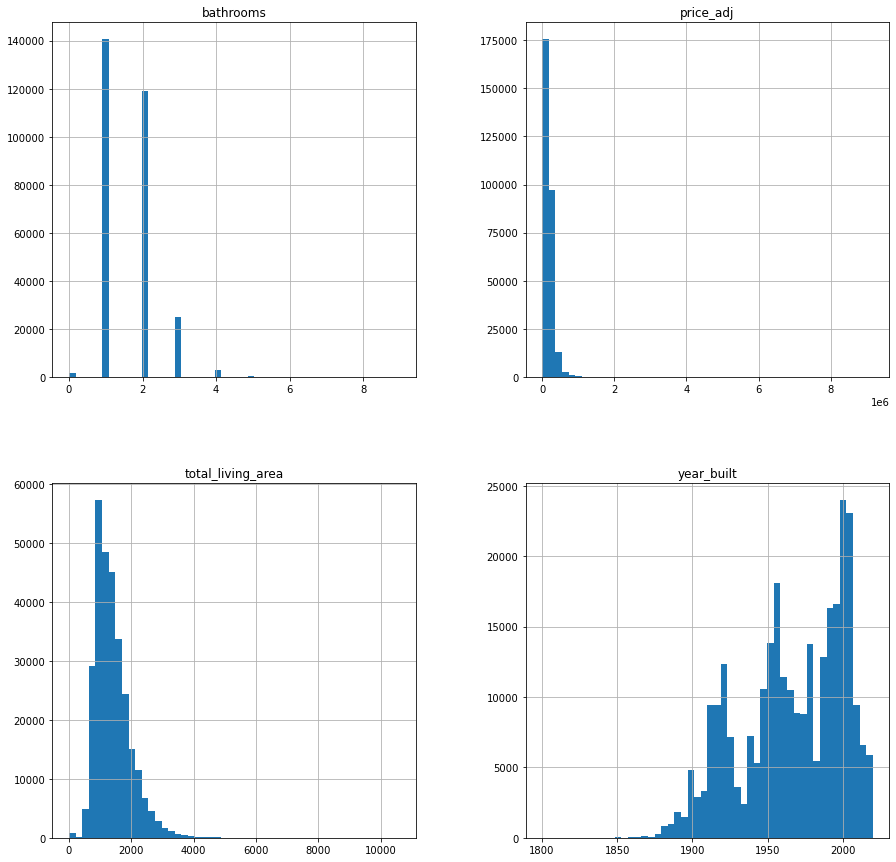

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

df2.hist(bins=50, figsize=(15,15))
plt.show()

#### Present histogram of year built

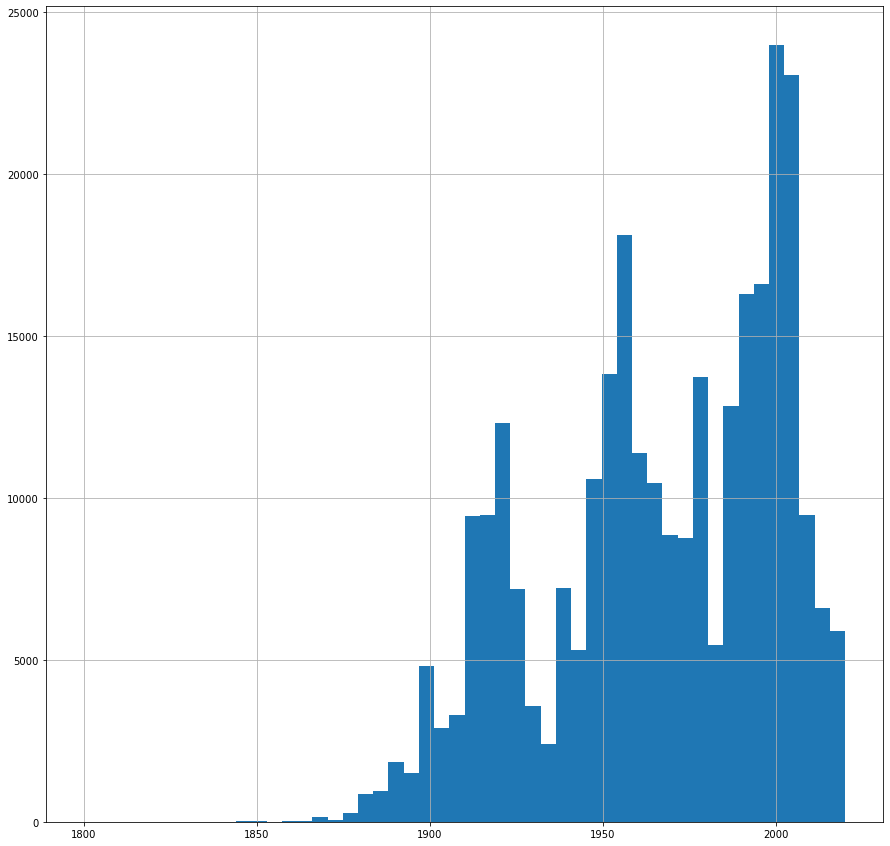

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
df_yearblt = df2.year_built

df_yearblt.hist(bins=50, figsize=(15,15))
plt.show()

### Build the regression model

#### Extract selected features and target to X and Y.  Split the data into test and train data.

In [29]:
from sklearn.model_selection import train_test_split
features = ['bathrooms','year_built','total_living_area']
X = df2[features].copy()
y = df2[['price_adj']]

X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.8,random_state=1)

#### Fit the model

In [30]:
from sklearn.linear_model import LinearRegression
# this did not always converge on the first attempt
lr=LinearRegression().fit(X_train, y_train)


#### Output accuracy scores of regression

In [31]:
from sklearn import metrics
lrprd=lr.predict(X_test)

mean_squared_error=metrics.mean_squared_error(y_test,lrprd)
print('Mean Squared Error (MSE) ', round(np.sqrt(mean_squared_error), 2))
print('R-squared (training) ', round(lr.score(X_train, y_train), 3))
print('R-squared (testing) ', round(lr.score(X_test, y_test), 3))
print('Intercept: ', lr.intercept_)
print('Coefficient: ', lr.coef_)

Mean Squared Error (MSE)  80295.04
R-squared (training)  0.54
R-squared (testing)  0.589
Intercept:  [-1915437.53689346]
Coefficient:  [[25678.53472109   963.38074412   113.91160689]]


#### Export model to pkl file

In [82]:
import joblib

with open("data/regressionModel.pkl", "wb") as fwb:
    joblib.dump(lr, fwb)